In [1]:
from pathlib import Path
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
import os
from torchvision.transforms import InterpolationMode
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
from PIL import Image
import time



torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")



PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1


In [3]:
torch.cuda.is_available()


True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Gathering the dataset from Kaggle

In [5]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", dataset_path)

Path to dataset files: C:\Users\-\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8


Building the dataset


In [6]:
# Create directories
train_directory = Path(dataset_path) / "train"
val_directory = Path(dataset_path) / "validation"
test_directory = Path(dataset_path) / "test"

train_file_paths = list(train_directory.glob("**/*.jpg"))
val_file_paths = list(val_directory.glob("**/*.jpg"))
test_file_paths = list(test_directory.glob("**/*.jpg"))

print(f"Found {len(train_file_paths)} training images")
print(f"Found {len(val_file_paths)} validation images")
print(f"Found {len(test_file_paths)} test images")


Found 2855 training images
Found 340 validation images
Found 340 test images


In [7]:
# Get the transforms from the weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

print(f"Transforms: {transforms}")
# 

Transforms: <module 'torchvision.transforms' from 'C:\\Users\\-\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\torchvision\\transforms\\__init__.py'>


In [8]:
# Create transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),  # Convert to tensor and scale to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                        std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
train_data = datasets.ImageFolder(train_directory, transform=train_transforms)
val_data = datasets.ImageFolder(val_directory, transform=val_transforms)
test_data = datasets.ImageFolder(test_directory, transform=test_transforms)

print(f"Train data: {train_data}")
print(f"Val data: {val_data}")
print(f"Test data: {test_data}")


Train data: Dataset ImageFolder
    Number of datapoints: 3115
    Root location: C:\Users\-\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Val data: Dataset ImageFolder
    Number of datapoints: 351
    Root location: C:\Users\-\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8\validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data: Dataset ImageFolder
   

In [10]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Using {NUM_WORKERS} workers for loading data")

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train loader: {train_loader}")
print(f"Val loader: {val_loader}")
print(f"Test loader: {test_loader}")


Using 16 workers for loading data
Train loader: <torch.utils.data.dataloader.DataLoader object at 0x000001F1A080BB60>
Val loader: <torch.utils.data.dataloader.DataLoader object at 0x000001F1A7357230>
Test loader: <torch.utils.data.dataloader.DataLoader object at 0x000001F1A0C96AB0>


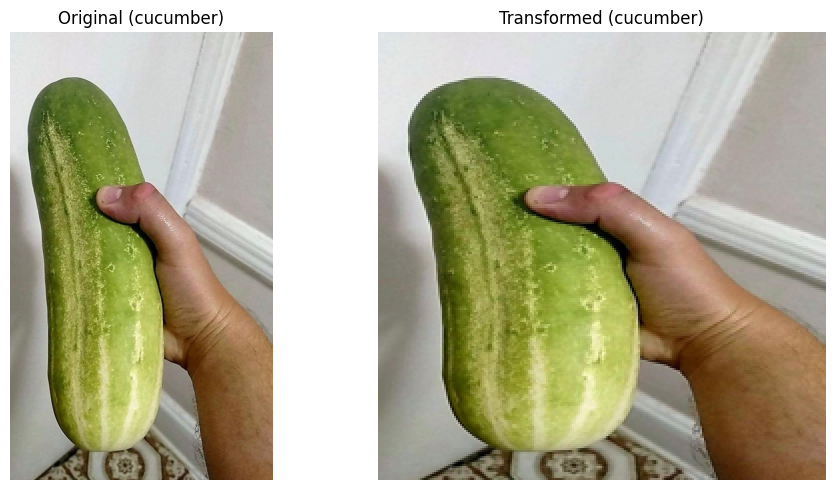

In [11]:
def show_images(img_path=None, class_name=None):
    # If no image provided, get a random one
    if img_path is None:
        idx = np.random.randint(len(train_data))
        img_path, label = train_data.samples[idx]
        class_name = train_data.classes[label]
    
    # Load and show original image
    original_img = Image.open(img_path).convert('RGB')  # Convert to RGB here
    
    # Transform image using our train_transforms
    transformed_img = train_transforms(original_img)
    
    # Denormalize for visualization
    transformed_img = transformed_img.permute(1, 2, 0).numpy()
    transformed_img = transformed_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    transformed_img = np.clip(transformed_img, 0, 1)
    
    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(original_img)
    ax1.set_title(f"Original ({class_name})")
    ax1.axis('off')
    
    ax2.imshow(transformed_img)
    ax2.set_title(f"Transformed ({class_name})")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

show_images()

In [12]:

# Import the weights
from torchvision.models import EfficientNet_B1_Weights

# Create the model with pretrained weights
model = models.efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
model = model.to(device) 


In [13]:
# describe the model
number_of_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {number_of_parameters}")
summary(model, 
        input_size=(BATCH_SIZE, 3, 224, 224),
        device=device,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])



Number of parameters: 7794184


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [14]:
# Check current number of output features
print(f"Current output features: {model.classifier[1].out_features}")

# Get number of classes in your dataset
num_classes = len(train_data.classes)
print(f"Number of classes in our dataset: {num_classes}")



Current output features: 1000
Number of classes in our dataset: 36


In [15]:
model.classifier[1] = nn.Linear(
    in_features=model.classifier[1].in_features,
    out_features=num_classes
)

# Verify the change
print(f"Updated output features: {model.classifier[1].out_features}")
model = model.to(device)

Updated output features: 36


In [16]:
# Setting up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the SummaryWriter to write TensorBoard logs
writer = SummaryWriter("logs/fruit_and_vegetable_recognition")

By running the learning function, I found out that the optimal number of learning epochs is 6, after which overfitting appears.
This would be the number of epochs for the model.

In [18]:
from engine import train_step, val_step, test_step
from tqdm.auto import tqdm

def train_model(model,
                train_loader,
                val_loader,
                test_loader,
                loss_fn,
                optimizer,
                num_epochs=10,
                device=device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = val_step(model, val_loader, loss_fn, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        writer.add_scalars("Loss",
                          tag_scalar_dict={
                              "train_loss": train_loss,
                              "val_loss": val_loss,
                              "test_loss": test_loss
                          },
                          global_step=epoch)       
        writer.add_scalars("Accuracy",
                            tag_scalar_dict={
                                "train_acc": train_acc,
                                "val_acc": val_acc,
                                "test_acc": test_acc
                            },
                            global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(BATCH_SIZE,3,224,224).to(device))
        
    writer.close()        

    return results

# Train the model
results = train_model(model, train_loader, val_loader, test_loader, loss_fn, optimizer, num_epochs=7, device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/7
Epoch: 1 | train_loss: 1.3898 | train_acc: 0.6258 | val_loss: 0.3907 | val_acc: 0.8579 | test_loss: 0.3974 | test_acc: 0.8579
Epoch 2/7
Epoch: 2 | train_loss: 0.4963 | train_acc: 0.8466 | val_loss: 0.1676 | val_acc: 0.9318 | test_loss: 0.1599 | test_acc: 0.9349
Epoch 3/7
Epoch: 3 | train_loss: 0.3154 | train_acc: 0.8882 | val_loss: 0.2116 | val_acc: 0.9119 | test_loss: 0.1957 | test_acc: 0.9193
Epoch 4/7
Epoch: 4 | train_loss: 0.2364 | train_acc: 0.9153 | val_loss: 0.1755 | val_acc: 0.9318 | test_loss: 0.1613 | test_acc: 0.9375
Epoch 5/7
Epoch: 5 | train_loss: 0.1746 | train_acc: 0.9426 | val_loss: 0.1204 | val_acc: 0.9545 | test_loss: 0.1122 | test_acc: 0.9583
Epoch 6/7
Epoch: 6 | train_loss: 0.1317 | train_acc: 0.9522 | val_loss: 0.1245 | val_acc: 0.9631 | test_loss: 0.1142 | test_acc: 0.9661
Epoch 7/7
Epoch: 7 | train_loss: 0.1873 | train_acc: 0.9338 | val_loss: 0.1364 | val_acc: 0.9460 | test_loss: 0.1251 | test_acc: 0.9505


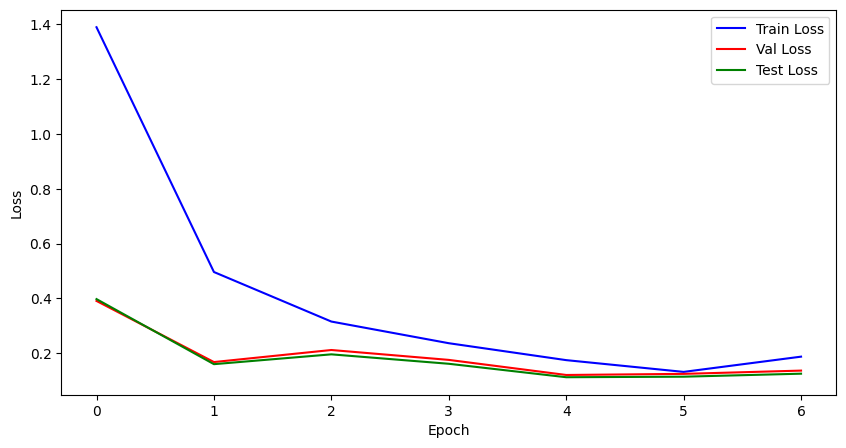

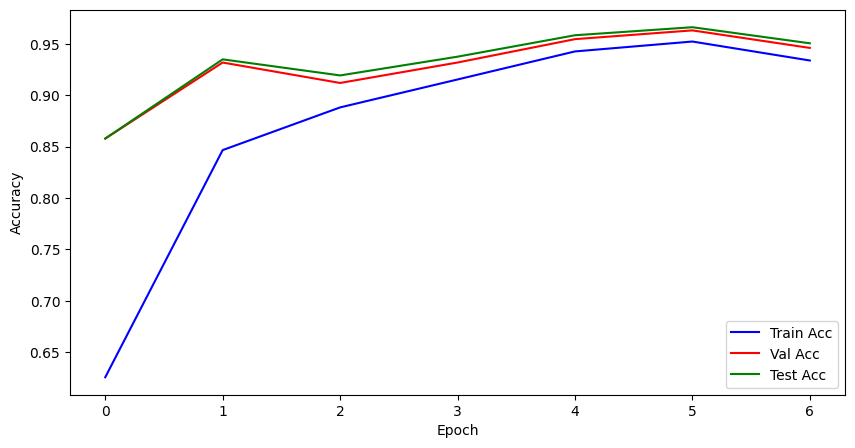

In [19]:
# Visualize Loss
def plot_results(results):
    plt.figure(figsize=(10, 5))
    plt.plot(results["train_loss"], label="Train Loss", color="blue")
    plt.plot(results["val_loss"], label="Val Loss", color="red")
    plt.plot(results["test_loss"], label="Test Loss", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Visualize Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(results["train_acc"], label="Train Acc", color="blue")
    plt.plot(results["val_acc"], label="Val Acc", color="red")
    plt.plot(results["test_acc"], label="Test Acc", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_results(results)

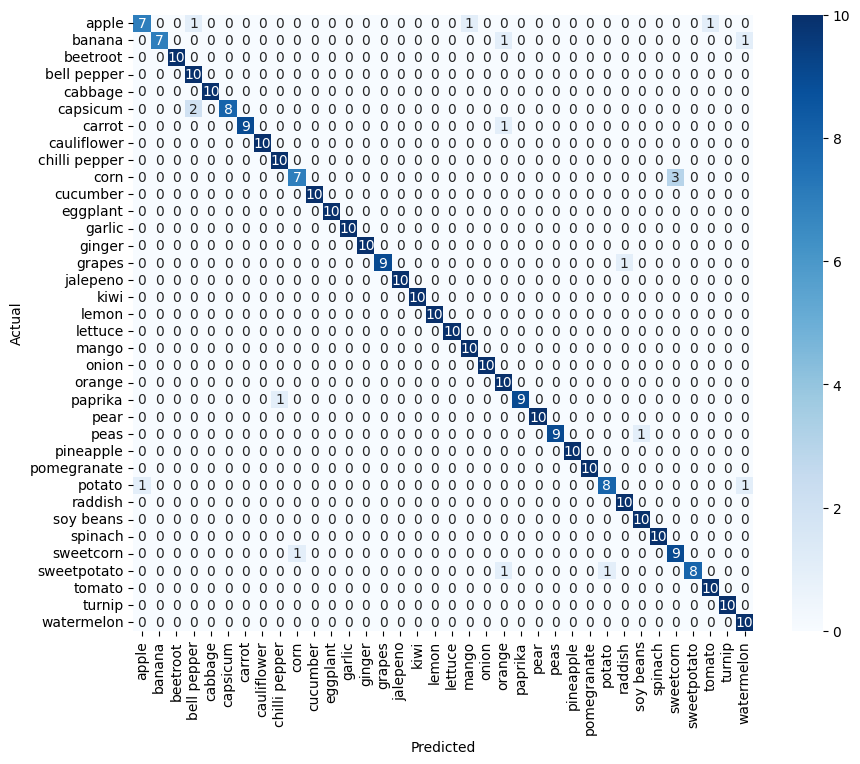

In [20]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(results):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(results)


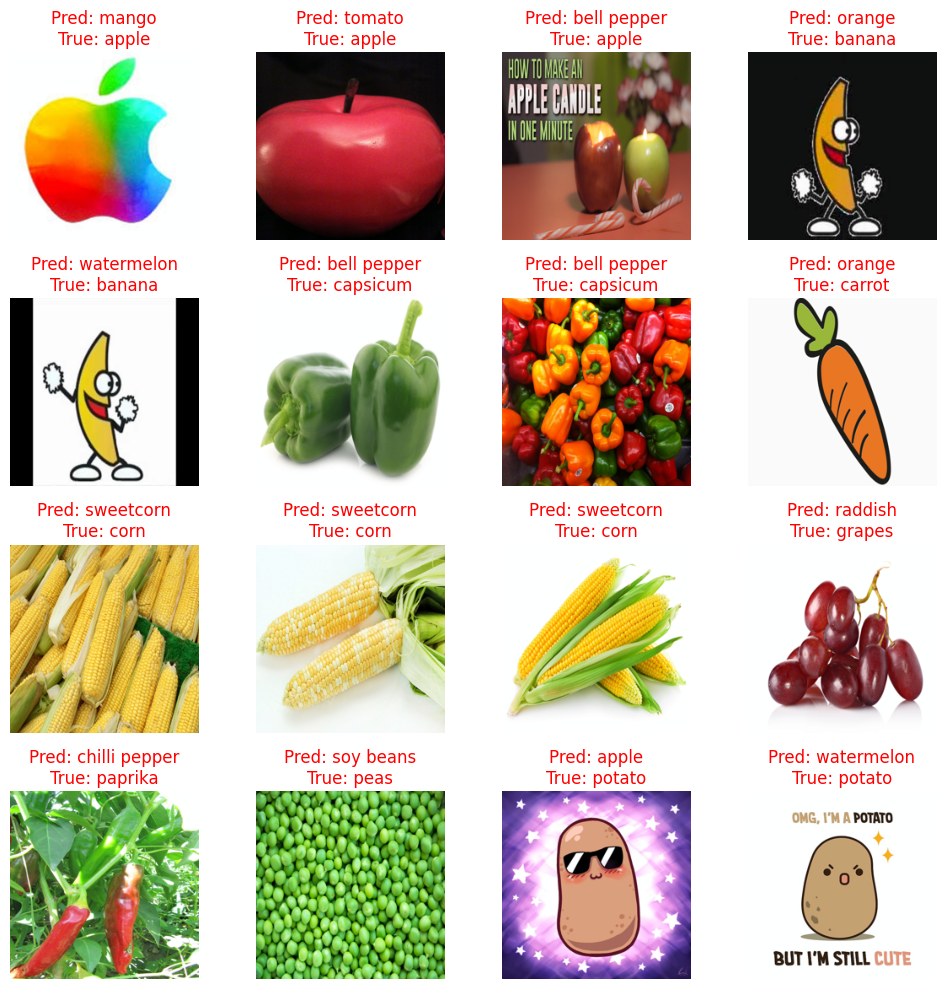

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_misclassified_images(model, dataloader, class_names, device, num_images=9):
    """
    Displays only misclassified test images with their predicted and actual labels.
    
    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test dataset.
        class_names: List of class labels.
        device: Device (CPU/GPU).
        num_images: Number of misclassified images to display.
    """
    model.eval()  # Set model to evaluation mode
    misclassified = []

    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Collect only misclassified images
            for img, pred, true_label in zip(images, preds, labels):
                if pred != true_label:  # Check for misclassification
                    misclassified.append((img.cpu(), pred.cpu(), true_label.cpu()))
                if len(misclassified) >= num_images:  # Stop if enough images are collected
                    break
            if len(misclassified) >= num_images:
                break

    if not misclassified:
        print("No misclassified images found!")
        return

    # Prepare images for visualization
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i, (img, pred, true_label) in enumerate(misclassified[:num_images]):
        ax = axes[i]
        img = img.permute(1, 2, 0).numpy()  # Convert to NumPy format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize
        img = np.clip(img, 0, 1)  # Clip pixel values

        pred_label = class_names[pred]
        true_label = class_names[true_label]

        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color="red")  # Red = incorrect
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_misclassified_images(model, test_loader, test_data.classes, device, num_images=16)

"Bell Pepper" and "Capsicum" are the most misclassified classes. I'm unsure if it makes sense to split them into two since they represent the same thing. However, I will leave the original data untouched. 

Moreover, the "Corn" and "Sweetcorn" classes also have some classification errors in the original dataset. I accept these issues, considering this exercise is for practice.